In [1]:
import os

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

from pykrige.ok import OrdinaryKriging

from air_brain.data.get_data import DATA_DIR
from air_brain.util.air import PM25
from air_brain.util.od import od

county_file = os.path.join(DATA_DIR, "county.geojson")
sensor_file = os.path.join(DATA_DIR, "sensor_json.geojson")

In [2]:
# county for masking, somehow???
county = gpd.read_file(county_file)
county = county.to_crs("EPSG:2272")

In [3]:
# point values of PM 2.5 AQI
sensors = gpd.read_file(sensor_file)
df = PM25().daily_air()
df = sensors[['SiteName', 'geometry']].rename(columns={'SiteName': 'site'}).merge(df, on='site', how='right', validate='1:m')

In [4]:
# need point measurement geometry as x,y grid, which should be ok, since this is a small area
# use southern PA coordinate system
df = df.to_crs("EPSG:2272")

In [5]:
# census tract geometry
tract_file = os.path.join(DATA_DIR, "tl_2010_42003_tract10", "tl_2010_42003_tract10.shp")
tracts = gpd.read_file(tract_file)
tracts = tracts.to_crs("EPSG:2272")
tracts.GEOID10 = tracts.GEOID10.astype(int)

<Axes: >

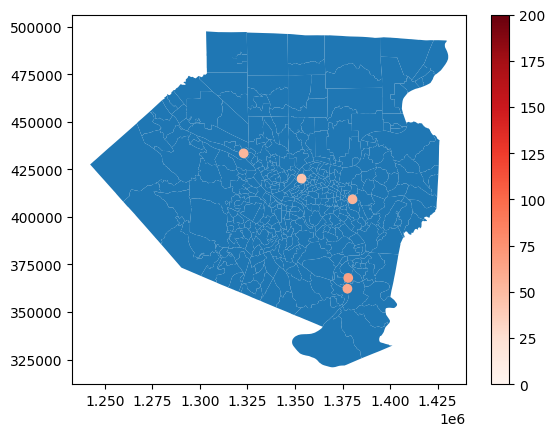

In [6]:
# plot of tracts vs sensors for one day
ax = tracts.plot()
date = pd.to_datetime('6/3/2017')
subset = df.loc[df.date == date]
subset.plot("index_value", ax=ax, legend=True, vmin=0, vmax=200, cmap="Reds")

In [7]:
# fit Kriging model
OK = OrdinaryKriging(
    subset.geometry.x,
    subset.geometry.y,
    subset.index_value,
    variogram_model="gaussian",
    verbose=False,
    enable_plotting=False,
)

In [8]:
# generate a grid of points to estimate from
# start with equally spaced within Allegheny County
bounds = county.total_bounds
# grid
cell_size = 1000
x_coords = np.arange(bounds[0], bounds[2], cell_size)
y_coords = np.arange(bounds[1], bounds[3], cell_size)
grid_points = [Point(x, y) for x in x_coords for y in y_coords]
grid_gdf = gpd.GeoDataFrame(geometry=grid_points, crs=county.crs)
grid_gdf = grid_gdf.clip(county)

In [9]:
# run Kriging
z, ss = OK.execute("points", grid_gdf.geometry.x, grid_gdf.geometry.y)

<Axes: >

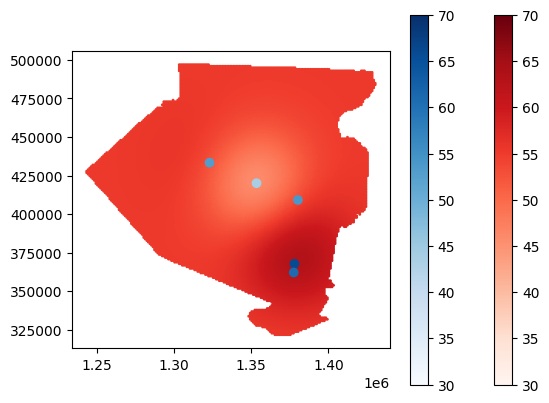

In [10]:
grid_gdf['estimate'] = z.data
ax = grid_gdf.plot(column='estimate', cmap='Reds', legend=True, vmin=30, vmax=70, s=1)
subset.plot("index_value", ax=ax, vmin=30, vmax=70, cmap="Blues", legend=True)

In [11]:
# used estimated point values to estimate an AQI averaged across a census tract
# because the asthma data is averaged across census tracts (and the OD data across zipcodes)
def estimate_area(geometry, estimate_gdf, estimate_col="estimate"):
    estimates_here = estimate_gdf.loc[estimate_gdf.within(geometry), estimate_col]
    avg_estimate = estimates_here.mean()
    return avg_estimate

tracts["estimate"] = tracts.geometry.apply(estimate_area, args=(grid_gdf,))

<Axes: >

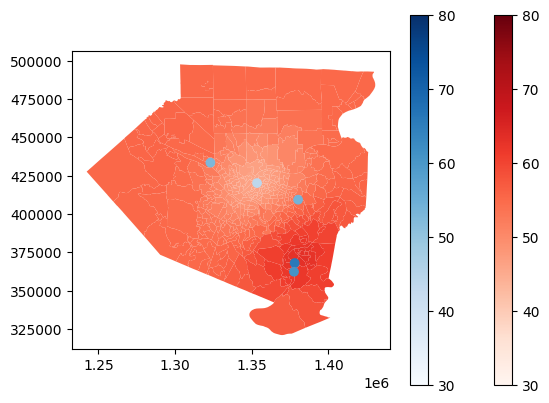

In [12]:
ax = tracts.plot(column="estimate", cmap="Reds", legend=True, vmin=30, vmax=80)
subset.plot("index_value", ax=ax, vmin=30, vmax=80, cmap="Blues", legend=True)

# repeat for all the days in 2017

In [13]:
def estimate_area(geometry, estimate_gdf, estimate_col="estimate"):
    estimates_here = estimate_gdf.loc[estimate_gdf.within(geometry), estimate_col]
    avg_estimate = estimates_here.mean()
    return avg_estimate

def one_day(pt_df, grid_gdf, area_df, date):
    # subset to just this date
    subset = pt_df.loc[pt_df.date == pd.to_datetime(date)]
    # fit Kriging model for this day
    OK = OrdinaryKriging(
        subset.geometry.x,
        subset.geometry.y,
        subset.index_value,
        variogram_model="gaussian",
        verbose=False,
        enable_plotting=False,
    )
    # run Kriging estimate for all points in grid
    z, ss = OK.execute("points", grid_gdf.geometry.x, grid_gdf.geometry.y)
    grid_gdf["estimate"] = z.data
    # used estimated point values to estimate across an area
    area_df["estimate"] = area_df.geometry.apply(estimate_area, args=(grid_gdf,))
    return area_df

In [14]:
all_estimates = dict()
for date in pd.date_range(pd.to_datetime("1/1/2017"), pd.to_datetime("12/31/2017")):
    ret = one_day(df, grid_gdf, tracts, date)
    all_estimates[date] = ret[["TRACTCE10", "estimate"]]

In [15]:
# average AQI for each tract in 2017
# TODO this is backwards and silly
for date, day_df in all_estimates.items():
    all_estimates[date] = day_df.set_index("TRACTCE10")

<Axes: >

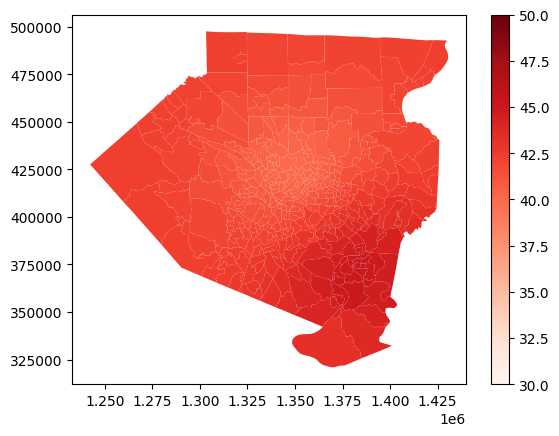

In [16]:
avg_aqi = pd.concat(all_estimates.values(), axis=1).mean(axis=1).reset_index().rename(columns={0: "index_value"})
# glue geometry back on
avg_aqi = tracts.merge(avg_aqi)
avg_aqi.plot(column="index_value", cmap="Reds", legend=True, vmin=30, vmax=50)

# how's that compare to asthma?

In [17]:
asthma_file = os.path.join(DATA_DIR, "asthma.csv")
asthma = pd.read_csv(asthma_file)
# convert all numerators to fractions
for col in ["ED_visits", "ED_hosp", "UC_visits", "Asthma_use"]:
    asthma["{}_frac".format(col)] = asthma[col] / asthma.Total_members

<Axes: >

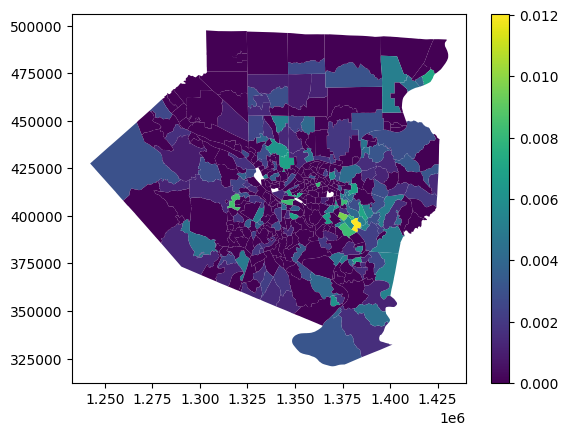

In [18]:
combo = avg_aqi.merge(asthma, right_on="Census_tract", left_on="GEOID10", validate="1:1")
combo.plot(column="UC_visits_frac", legend=True)

<Axes: xlabel='index_value', ylabel='UC_visits_frac'>

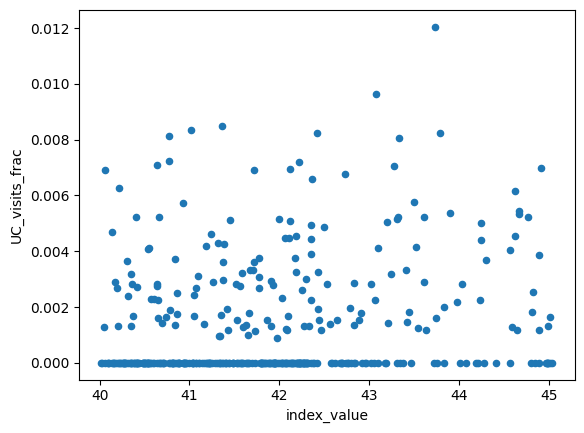

In [19]:
combo[["index_value", "UC_visits_frac"]].plot(x="index_value", y="UC_visits_frac", kind="scatter")